In [1]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from unityagents import UnityEnvironment
import torch

## Load DDPG agent

In [3]:
from ddpg_agent import DDPGAgent

## Load environment

In [4]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine states and action spaces

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Actor and Critic model architecture details and set parameters

In [7]:
in_critic = num_agents*(state_size + action_size)

hidden_in_actor = 256
hidden_out_actor = 128
hidden_in_critic = 256
hidden_out_critic = 128

out_actor = action_size

In [8]:
num_agents = len(env_info.agents)
in_actor = state_size * num_agents

In [9]:
eps_start = 6           # Noise level start
eps_end = 0             # Noise level end
eps_decay = 250         # Number of episodes to decay over from start to end

### Initialize agents

In [10]:
agents = [DDPGAgent(in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic) for _ in range(num_agents)]

## Training multi agent DDPG agents

In [11]:
def ddpg_train_agents(n_episodes=4000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, n_agents = num_agents):
    """DDPG Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        n_agents (int): Number of agents 
    """
    scores = []                        # list containing scores from each episode
    all_scores_windows = []
    
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    for i_episode in range(1, n_episodes+1):
        #print("Episode: ", i_episode)
        env_info = env.reset(train_mode = True)[brain_name]
        states = env_info.vector_observations
        scores_temp = np.zeros(n_agents)
        states = np.reshape(states, (1, 48))
        while True:
            actions = np.zeros((n_agents,2))
            for i in range(n_agents):
                actions[i,:] = agents[i].act(states, eps)
            actions_npy = actions.reshape(1,-1)[0]
            env_info = env.step(actions_npy)[brain_name]
            next_states = env_info.vector_observations
            next_states = np.reshape(next_states, (1, 48))
            rewards = env_info.rewards
            dones = env_info.local_done
            for i in range(n_agents):
                agents[i].step(states, actions_npy, rewards[i], next_states, dones[i], i)
            states = next_states
            scores_temp += np.array(rewards)
            if np.any(dones):
                break
                
        max_scores = np.max(scores_temp)
        scores_window.append(max_scores)       # save most recent score
        scores.append(max_scores)              # save most recent score
        all_scores_windows.append(np.mean(scores_window))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 200 == 0:
            for i in range(n_agents):
                torch.save(agents[i].target_actor.state_dict(), f'checkpoint_{i}.pth')
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            for i in range(n_agents):
                torch.save(agents[i].target_actor.state_dict(), f'solved_checkpoint_{i}.pth')
            break
    return scores, all_scores_windows

## Scores per episode

In [12]:
scores = ddpg_train_agents()

Episode 50	Average Score: 0.02720
Episode 100	Average Score: 0.02210
Episode 150	Average Score: 0.01450
Episode 200	Average Score: 0.00800
Episode 250	Average Score: 0.00500
Episode 300	Average Score: 0.00700
Episode 350	Average Score: 0.01400
Episode 400	Average Score: 0.02580
Episode 450	Average Score: 0.02460
Episode 500	Average Score: 0.02260
Episode 550	Average Score: 0.03030
Episode 600	Average Score: 0.02620
Episode 650	Average Score: 0.01350
Episode 700	Average Score: 0.01650
Episode 750	Average Score: 0.02250
Episode 800	Average Score: 0.01450
Episode 850	Average Score: 0.01530
Episode 900	Average Score: 0.01930
Episode 950	Average Score: 0.01910
Episode 1000	Average Score: 0.02220
Episode 1050	Average Score: 0.02250
Episode 1100	Average Score: 0.02340
Episode 1150	Average Score: 0.04780
Episode 1200	Average Score: 0.06380
Episode 1250	Average Score: 0.03720
Episode 1300	Average Score: 0.02670
Episode 1350	Average Score: 0.04610
Episode 1400	Average Score: 0.05050
Episode 1450

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

## Plot of rewards and average over 100 consecutive rewards (shown in orange)

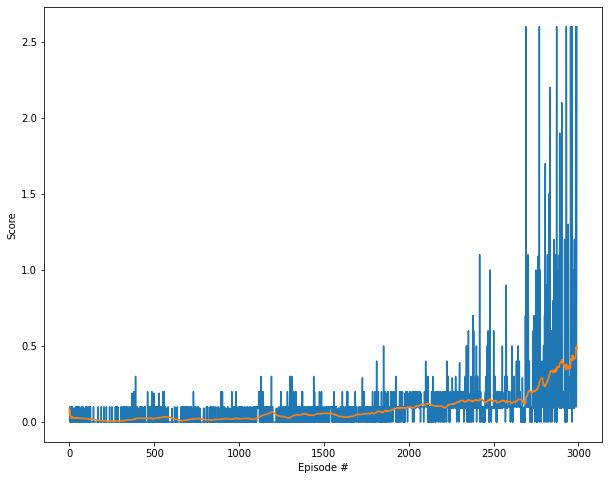

In [15]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores[0])+1), scores[0])
plt.plot(np.arange(1, len(scores[1])+1), scores[1])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Test the solved agents to play

In [16]:
from model import DDPGNet
target_actor1 = DDPGNet(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor = True)
target_actor2 = DDPGNet(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor = True)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
target_actor1.load_state_dict(torch.load('solved_checkpoint_0.pth'))
target_actor2.load_state_dict(torch.load('solved_checkpoint_1.pth'))

target_actor1.to(device)
target_actor2.to(device)

DDPGNet(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [20]:
def actor_act(target_actor, state, eps = 0.0):
    #import pdb;pdb.set_trace()
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    state = np.reshape(state, (1,48)).cuda()
    target_actor.eval()
    #import pdb; pdb.set_trace()
    with torch.no_grad():
        action_values = target_actor(state)
    #target_actor.train()
    action_vals_npy = action_values.cpu().data.numpy()
    return np.clip(action_vals_npy, -1, 1)

In [21]:
for i in range(1, 60):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions[0,:] = actor_act(target_actor1, states, eps = 0.0)
        actions[1,:] = actor_act(target_actor2, states, eps = 0.0)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.4000000059604645
Score (max over agents) from episode 2: 0.4000000059604645
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.20000000298023224
Score (max over agents) from episode 5: 0.30000000447034836
Score (max over agents) from episode 6: 0.10000000149011612
Score (max over agents) from episode 7: 0.20000000298023224
Score (max over agents) from episode 8: 0.20000000298023224
Score (max over agents) from episode 9: 0.20000000298023224
Score (max over agents) from episode 10: 0.0
Score (max over agents) from episode 11: 0.10000000149011612
Score (max over agents) from episode 12: 0.6000000089406967
Score (max over agents) from episode 13: 0.20000000298023224
Score (max over agents) from episode 14: 0.0
Score (max over agents) from episode 15: 0.20000000298023224
Score (max over agents) from episode 16: 0.20000000298023224
Score (max over agents) from episode 17: 0.20000000298023224
Score (

In [22]:
env.close()